# Variational Autoencoder

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
print (sys.version)

3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 14:01:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import importlib
import pandas as pd
from scipy.stats import bernoulli
from matplotlib import cm
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot
import random

import generative_lib

In [4]:
importlib.reload(generative_lib)

<module 'generative_lib' from '/Users/joriococola/Desktop/CS 6140/project 6140/GitHub/CS6140_LatentClassify/ipython notebooks/generative_lib.py'>

In [5]:
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

## Setting

In [6]:
# Dataset
random_seed = 123
DOWNLOAD = True
SHUFFLE_TR = True
SHUFFLE_TS = False

# Architecture
num_features = 784
num_hidden_1 = 150
num_latent = 32

device = "cpu"

# Training
learning_rate = 0.0005
num_epochs = 6
batch_size = 28

## MNIST DATASET

In [7]:
# Note transforms.ToTensor() scales input images to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=DOWNLOAD)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

In [8]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=SHUFFLE_TR)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=SHUFFLE_TS)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([28, 1, 28, 28])
Image label dimensions: torch.Size([28])


## Model

In [9]:
torch.manual_seed(random_seed)
model = generative_lib.VAE(num_features, num_hidden_1, num_latent)

In [11]:
path = '/Users/joriococola/Desktop/CS 6140/project 6140/GitHub/CS6140_LatentClassify/trained models/VAE_MNIST.pt'
model.load_state_dict(torch.load(path ,map_location='cpu'))
model.eval()
generative_lib.froze_weights(model)

## Evaluation

### Test set

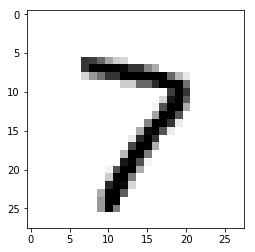

In [32]:
# Random img in the test set
test_img = test_dataset[random.randint(0, len(test_dataset))][0]
plt.imshow(test_img.reshape([image_width,image_width]),cmap='binary')

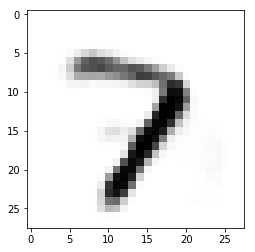

In [33]:
# Reconstruction using autoencoder
[test_enc,z_mean,z_log_var] = model.encoder(test_img.reshape([1,image_width*image_width]))
test_dec = model.decoder(test_enc).detach().numpy()

plt.imshow(test_dec.reshape([image_width,image_width]),cmap='binary')

## Latent Codes

In [34]:
batch_size = len(train_dataset)
batch_size_test = len(test_dataset)
SHUFFLE_TR = False
SHUFFLE_TS = False

Xtrain = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=SHUFFLE_TR)
Xtest = DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=SHUFFLE_TS)

In [35]:
for batch_idx, (features, targets_tr) in enumerate(Xtrain):
    features_tr = features.view(-1, 28*28)
print(batch_idx)

0


In [36]:
features_tr.shape

torch.Size([60000, 784])

In [37]:
[latent_tr,z_mean,z_log_var] = model.encoder(features_tr)
print(latent_tr.shape)
print(targets_tr.shape)

torch.Size([60000, 32])
torch.Size([60000])


In [38]:
for batch_idx, (features, targets_ts) in enumerate(Xtest):
    features_ts = features.view(-1, 28*28)
print(batch_idx)

0


In [39]:
[latent_ts,z_mean,z_log_var] = model.encoder(features_ts)
print(latent_ts.shape)
print(targets_ts.shape)

torch.Size([10000, 32])
torch.Size([10000])


In [40]:
torch.save(latent_tr, 'VAE_MNIST-latent_tr.pth')
torch.save(latent_ts, 'VAE_MNIST-latent_ts.pth')

torch.save(targets_tr, 'VAE_MNIST-targets_tr.pth')
torch.save(targets_ts, 'VAE_MNIST-targets_ts.pth')

In [56]:
tmp = torch.load('VAE_MNIST-latent_tr.pth')
tmp.shape

torch.Size([60000, 32])

# Creating Generator from AE

In [41]:
generator = generative_lib.VAE_gen(num_features, num_hidden_1, num_latent)

In [42]:
# copying weight in the generator
net_weight_dict = model.state_dict()
gen_weight_dict = {}

gen_weight_dict['linear_3.weight'] = net_weight_dict['linear_3.weight']
gen_weight_dict['linear_3.bias']   = net_weight_dict['linear_3.bias']
gen_weight_dict['linear_4.weight'] = net_weight_dict['linear_4.weight']
gen_weight_dict['linear_4.bias']   = net_weight_dict['linear_4.bias']

generator.load_state_dict(gen_weight_dict)

In [43]:
# freeze weigths
generative_lib.froze_weights(generator)

# Projection

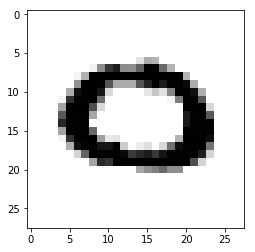

In [44]:
# Random img in the test set
test_img = test_dataset[random.randint(0, len(test_dataset))][0]
plt.imshow(test_img.reshape([image_width,image_width]),cmap='binary')

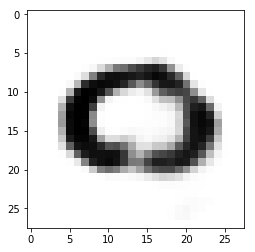

In [45]:
# Reconstruction using autoencoder
[test_enc,z_mean,z_log_var] = model.encoder(test_img.reshape([1,image_width*image_width]))
test_dec = model.decoder(test_enc).detach().numpy()

plt.imshow(test_dec.reshape([image_width,image_width]),cmap='binary')

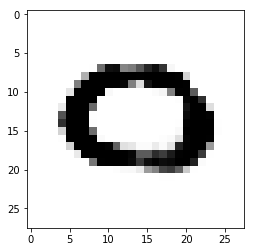

In [46]:
# reconstruction by projection
maxit = 500
gamma  = 0.5
x0    = test_enc*20-10
Gstar = test_img.reshape(image_width*image_width) #model.decoder(test_enc).detach()
rand_init = 1
sigma = 5

[l2_loss_var,xk2] = generative_lib.Full_Projection(generator, Gstar, maxit, gamma, rand_init, sigma, x0, generative_lib.L2_Project)

pctk2 = generator(xk2)
plt.imshow(pctk2.cpu().detach().numpy().reshape(28,28),  cmap='Greys')

In [47]:
tmp = test_dec.reshape(image_width*image_width) - test_img.reshape(image_width*image_width)
print(torch.norm(tmp))

tensor(3.2336)


In [48]:
tmp = pctk2.reshape(image_width*image_width) - test_img.reshape(image_width*image_width)
print(torch.norm(tmp))

tensor(2.1210)
